In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import datetime

sns.set_theme("notebook")
%matplotlib inline

### Chargement des données, séparé par machine

In [2]:
df = pd.read_csv("../../data/prepared_data/dataset.csv")

df_by_machine = df.groupby("machineID")

##### Age et nombre de défaillances par type de machine

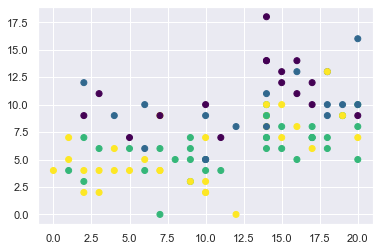

In [3]:
data=[]
ages=[]
modeles =[]
for i in range(1,100):
    df_machine = df_by_machine.get_group(i)
    ages.append(df_machine["age"].values[0])
    modeles.append(int(df_machine["model"].values[0][5]))
    data.append(df_machine["total_failure"].sum())
plt.scatter(ages,data,c=modeles,cmap='viridis')

### Calcul des corrélations en télémétry

In [4]:
telemetry_df=df[['volt_mean', 'volt_std', 'rotate_mean', 'rotate_std','pressure_mean', 'pressure_std', 'vibration_mean', 'vibration_std','comp1', 'comp2', 'comp3', 'comp4', 'total_failure']]

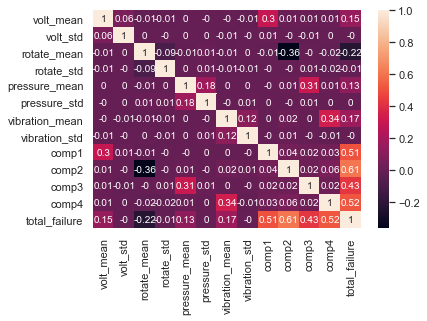

In [52]:
matrix = telemetry_df.corr().round(2)
sns.heatmap(matrix, annot=True)

plt.savefig("../../Images/Correlation_tel.jpg")

On observe les corrélations suivantes entre la télémétrie et les défaillances: 
    - Volt_mean avec Comp1, 
    - Rotate_mean avec Comp2 (négativement), 
    - Pressure_mean avec Comp3,
    - Vibration_mean avec Comp4

On observe les corrélations suivantes entre les erreurs et les défaillances: - Error1 avec Comp1, - Error2 et Error3 avec Comp2 , - Error4 avec Comp3, - Error5 avec Comp4

### Visualisation des corrélations détectées

Coloriage par defaillance, représentation par age du composant

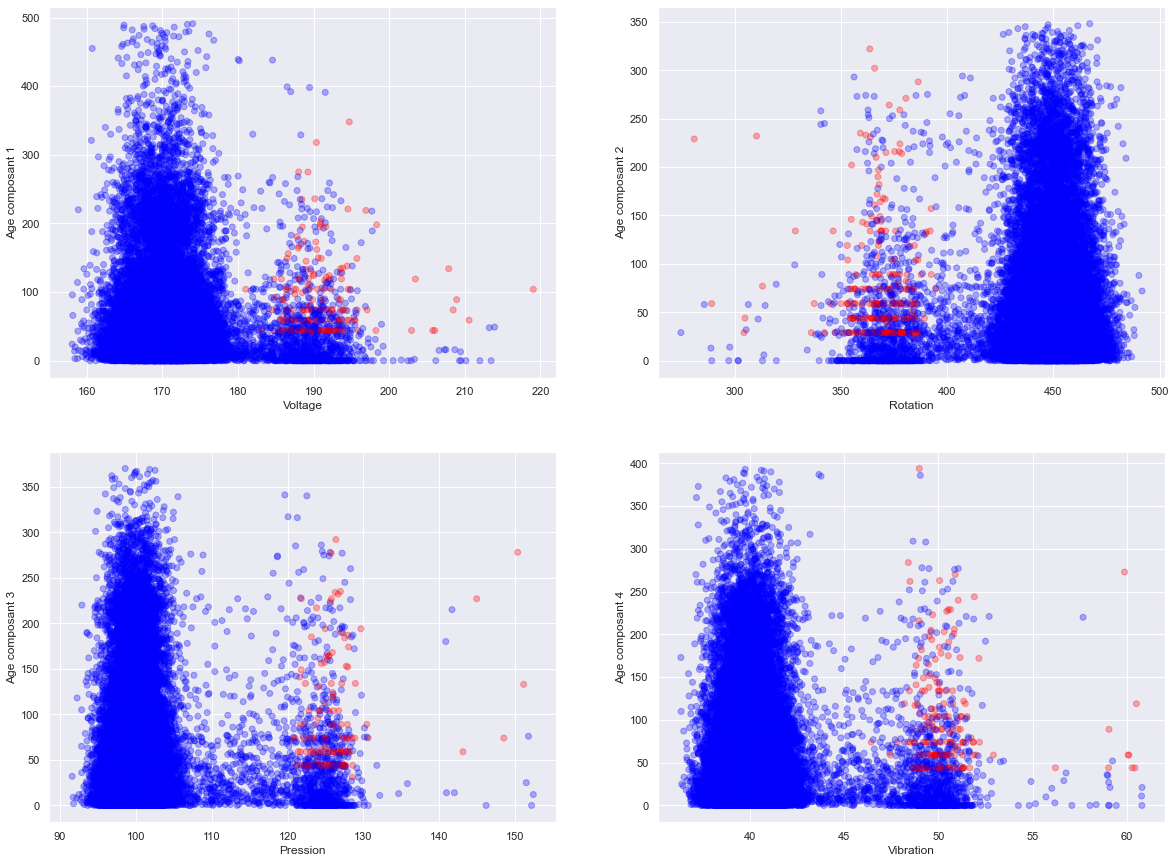

In [51]:
plt.figure(figsize=(20,15))
plt.subplot(221) #la specification de la sous courbe doit être faite en spécifiant 3 chiffres
plt.scatter(df['volt_mean'],df['comp1_delay'],c=df['comp1'],cmap='bwr', alpha=0.3)
plt.xlabel('Voltage')
plt.ylabel('Age composant 1')
plt.subplot(222) 
plt.scatter(df['rotate_mean'],df['comp2_delay'],c=df['comp2'],cmap='bwr', alpha=0.3)
plt.xlabel('Rotation')
plt.ylabel('Age composant 2')
plt.subplot(223)
plt.scatter(df['pressure_mean'],df['comp3_delay'],c=df['comp3'],cmap='bwr', alpha=0.3)
plt.xlabel("Pression")
plt.ylabel("Age composant 3")
plt.subplot(224) 
plt.scatter(df['vibration_mean'],df['comp4_delay'],c=df['comp4'],cmap='bwr', alpha=0.3)
plt.xlabel("Vibration")
plt.ylabel("Age composant 4")
plt.savefig("../../Images/2Dgraphs.jpg")

### Calcul des corrélations avec les erreurs

On va afficher une autre matrice de corrélation: entre les erreurs détectées et les défaillances

In [10]:
errors_df=df[['error1', 'error2', 'error3', 'error4','error5', 'comp1', 'comp2', 'comp3', 'comp4', 'total_failure']]

<AxesSubplot:>

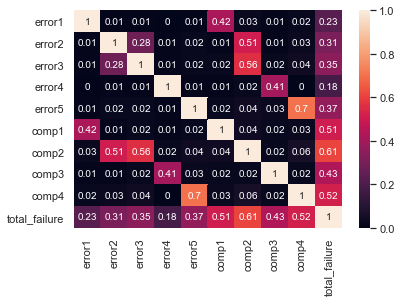

In [11]:
matrix = errors_df.corr().round(2)
sns.heatmap(matrix, annot=True)

plt.savefig("../../Images/Correlation_tel.jpg")

On observe les corrélations suivantes entre les erreurs et les défaillances: - Error1 avec Comp1, - Error2 et Error3 avec Comp2 , - Error4 avec Comp3, - Error5 avec Comp4

On ajoute ça dans nos graphes précédents

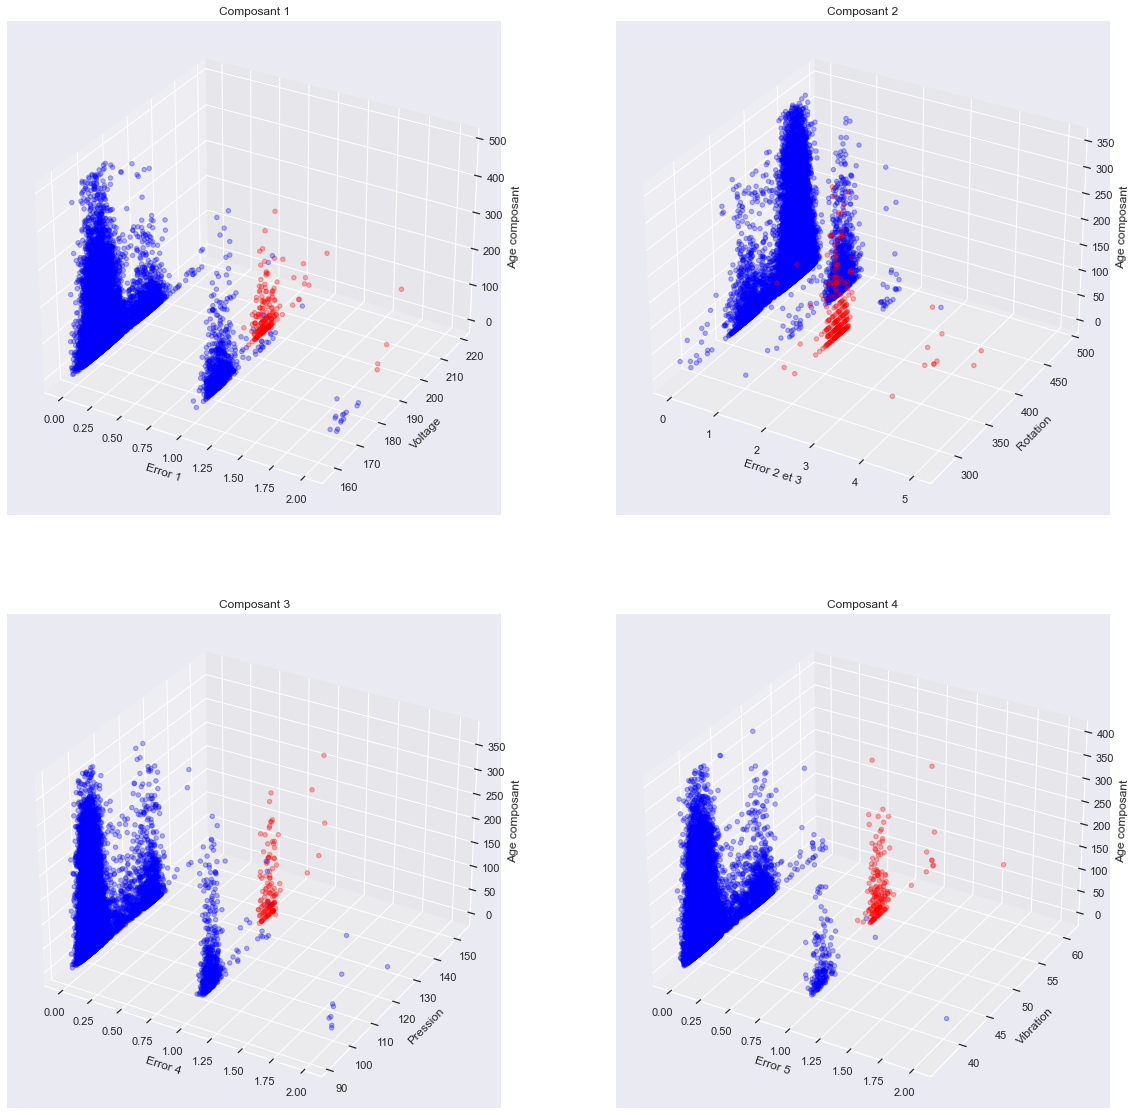

In [49]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(2,2,1,projection='3d')
ax.scatter(df['error1'],df['volt_mean'],df['comp1_delay'],c=df['comp1'],cmap='bwr', alpha=0.3)
ax.set_xlabel('Error 1', linespacing=3.2)
ax.set_ylabel('Voltage', linespacing=3.1)
ax.set_zlabel('Age composant', linespacing=3.4)
ax.set_title('Composant 1')
ax = fig.add_subplot(2,2,2,projection='3d')
ax.scatter(df['error2']+df['error3'],df['rotate_mean'],df['comp2_delay'],c=df['comp2'],cmap='bwr', alpha=0.3)
ax.set_xlabel('Error 2 et 3', linespacing=3.2)
ax.set_ylabel('Rotation', linespacing=3.1)
ax.set_zlabel('Age composant', linespacing=3.4)
ax.set_title('Composant 2')
ax = fig.add_subplot(2,2,3,projection='3d')
ax.scatter(df['error4'],df['pressure_mean'],df['comp3_delay'],c=df['comp3'],cmap='bwr', alpha=0.3)
ax.set_xlabel('Error 4', linespacing=3.2)
ax.set_ylabel('Pression', linespacing=3.1)
ax.set_zlabel('Age composant', linespacing=3.4)
ax.set_title('Composant 3')
ax = fig.add_subplot(2,2,4,projection='3d')
ax.scatter(df['error5'],df['vibration_mean'],df['comp4_delay'],c=df['comp4'],cmap='bwr', alpha=0.3)
ax.set_xlabel('Error 5', linespacing=3.2)
ax.set_ylabel('Vibration', linespacing=3.1)
ax.set_zlabel('Age composant', linespacing=3.4)
ax.set_title('Composant 4')
fig.savefig("../../Images/3Dgraphs.jpg")

Les données sont très bien séparées sur ces graphiques en 3D: On peut implémenter un algorithme de plus proche voisins en utilisant seulement les entrées pertinentes.

In [16]:
X1 = df[['error1','volt_mean','comp1_delay']]
y1 = df['comp1']


X2 = df[['error2','error3','rotate_mean','comp2_delay']]
y2 = df['comp2']

X3 = df[['error4','pressure_mean','comp3_delay']]
y3 = df['comp3']

X4 = df[['error5','vibration_mean','comp4_delay']]
y4 = df['comp4']

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, make_scorer, confusion_matrix

def neighbor_comp(X,y):
    #séparation entre données d'entrainenment et données de test
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.5, random_state=42)

    # standardisation des donnée
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # création de la métrique d'évaluation du modèle
    ftwo_scorer = make_scorer(fbeta_score, beta=2, zero_division=0)

    #entrainement du modèle et prédiction
    parameters={'n_neighbors':[1,2,3,5,8,10]}
    cl = KNeighborsClassifier()
    clf = GridSearchCV(cl,param_grid=parameters,scoring=ftwo_scorer, verbose=4)
    clf.fit(X_train, Y_train)

    print(clf.best_params_)

    y_pred = clf.predict(X_test)
    print(confusion_matrix(Y_test,y_pred))
    

In [18]:
neighbor_comp(X1,y1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ..................................n_neighbors=1; total time=   0.2s
[CV 2/5] END ..................................n_neighbors=1; total time=   0.2s
[CV 3/5] END ..................................n_neighbors=1; total time=   0.2s
[CV 4/5] END ..................................n_neighbors=1; total time=   0.2s
[CV 5/5] END ..................................n_neighbors=1; total time=   0.2s
[CV 1/5] END ..................................n_neighbors=2; total time=   0.2s
[CV 2/5] END ..................................n_neighbors=2; total time=   0.2s
[CV 3/5] END ..................................n_neighbors=2; total time=   0.2s
[CV 4/5] END ..................................n_neighbors=2; total time=   0.2s
[CV 5/5] END ..................................n_neighbors=2; total time=   0.2s
[CV 1/5] END ..................................n_neighbors=3; total time=   0.2s
[CV 2/5] END ..................................n_

In [19]:
neighbor_comp(X2,y2)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ..................................n_neighbors=1; total time=   0.3s
[CV 2/5] END ..................................n_neighbors=1; total time=   0.3s
[CV 3/5] END ..................................n_neighbors=1; total time=   0.3s
[CV 4/5] END ..................................n_neighbors=1; total time=   0.3s
[CV 5/5] END ..................................n_neighbors=1; total time=   0.3s
[CV 1/5] END ..................................n_neighbors=2; total time=   0.3s
[CV 2/5] END ..................................n_neighbors=2; total time=   0.3s
[CV 3/5] END ..................................n_neighbors=2; total time=   0.3s
[CV 4/5] END ..................................n_neighbors=2; total time=   0.3s
[CV 5/5] END ..................................n_neighbors=2; total time=   0.3s
[CV 1/5] END ..................................n_neighbors=3; total time=   0.3s
[CV 2/5] END ..................................n_

In [20]:
neighbor_comp(X3,y3)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ..................................n_neighbors=1; total time=   0.2s
[CV 2/5] END ..................................n_neighbors=1; total time=   0.2s
[CV 3/5] END ..................................n_neighbors=1; total time=   0.2s
[CV 4/5] END ..................................n_neighbors=1; total time=   0.2s
[CV 5/5] END ..................................n_neighbors=1; total time=   0.2s
[CV 1/5] END ..................................n_neighbors=2; total time=   0.2s
[CV 2/5] END ..................................n_neighbors=2; total time=   0.2s
[CV 3/5] END ..................................n_neighbors=2; total time=   0.2s
[CV 4/5] END ..................................n_neighbors=2; total time=   0.2s
[CV 5/5] END ..................................n_neighbors=2; total time=   0.2s
[CV 1/5] END ..................................n_neighbors=3; total time=   0.2s
[CV 2/5] END ..................................n_

In [21]:
neighbor_comp(X4,y4)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ..................................n_neighbors=1; total time=   0.2s
[CV 2/5] END ..................................n_neighbors=1; total time=   0.2s
[CV 3/5] END ..................................n_neighbors=1; total time=   0.2s
[CV 4/5] END ..................................n_neighbors=1; total time=   0.2s
[CV 5/5] END ..................................n_neighbors=1; total time=   0.2s
[CV 1/5] END ..................................n_neighbors=2; total time=   0.2s
[CV 2/5] END ..................................n_neighbors=2; total time=   0.2s
[CV 3/5] END ..................................n_neighbors=2; total time=   0.2s
[CV 4/5] END ..................................n_neighbors=2; total time=   0.2s
[CV 5/5] END ..................................n_neighbors=2; total time=   0.2s
[CV 1/5] END ..................................n_neighbors=3; total time=   0.2s
[CV 2/5] END ..................................n_